In [12]:
import os
from typing import TypedDict, Annotated, List, Union, Sequence
import operator
import json
from dotenv import load_dotenv

from langchain import hub
from langchain.tools import BaseTool, StructuredTool, Tool, tool
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain_openai.chat_models import ChatOpenAI
from langchain.agents import create_openai_functions_agent
from langchain_core.utils.function_calling import convert_to_openai_function

from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, FunctionMessage

from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode, ToolInvocation
from langgraph.prebuilt.tool_executor import ToolExecutor

In [13]:
load_dotenv()

True

### core concepts
langchain => langgraph

- chain: 更多是 linear chain，链式顺序执行；
  - LCEL
- graph：可以有分支/判断（是否到达 AgentFinish），有循环
  - ReAct（Reasoning & Acting）其实本质上也不是 linear chain 了；

Graph

- nodes, edges
  - 每个节点都是一个函数
  - 所有节点的输入都是 state，输出会附加一些信息到新的 state 里
- state 沿着 edge 从一个 node 到另一个 node 时，state 会发生变化（携带上一个 node 的执行输出信息）

In [14]:
from IPython.display import Image

In [15]:
Image(url='https://miro.medium.com/v2/resize:fit:1400/format:webp/1*bkNjqXR1LjAVJQbNLpfYvA.png', width=500)

### examples 1: Agent Executor

In [16]:
os.environ["LANGCHAIN_PROJECT"] = "lg_01_agent_executor"

In [17]:
class AgentState(TypedDict):
   input: str
   chat_history: list[BaseMessage]
   agent_outcome: Union[AgentAction, AgentFinish, None]
    # 不断追加和传递
   intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

### tools
Tools are interfaces that an agent can use to interact with the world. They combine a few things:

- The name of the tool
- A description of what the tool is
- JSON schema of what the inputs to the tool are
- The function to call

In [18]:
import random

@tool("upper_case", return_direct=True)
def to_upper_case(input:str) -> str:
  """Returns the input as all upper case."""
  return input.upper()

@tool("random_number", return_direct=True)
def random_number_maker(input:str) -> str:
    """Returns a random number between 0-100."""
    return random.randint(0, 100)

tools = [to_upper_case,random_number_maker]

In [19]:
random_number_maker.run('random')

6

In [20]:
to_upper_case.run('hello WORLD')

'HELLO WORLD'

### Agent

In [21]:
# https://smith.langchain.com/hub/hwchase17/openai-functions-agent

prompt = hub.pull('hwchase17/openai-functions-agent')
llm = ChatOpenAI(model="gpt-4o", streaming=True)
prompt

ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], optional_variables=['chat_history'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='

In [22]:
agent = create_openai_functions_agent(llm, tools, prompt)

In [23]:
type(agent)

langchain_core.runnables.base.RunnableSequence

In [24]:
inputs = {"input": "give me a random number and then write in words and make it upper case.",
          "chat_history": [],
          "intermediate_steps":[]}

agent_outcome = agent.invoke(inputs)

In [25]:
agent_outcome

AgentActionMessageLog(tool='random_number', tool_input={'input': 'get a random number'}, log="\nInvoking: `random_number` with `{'input': 'get a random number'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"get a random number"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_80956533cb', 'service_tier': 'default'}, id='run--52ab639d-8d16-49d4-9167-c5a49272aea5-0')])

### tools

In [26]:
tool_executor = ToolExecutor(tools)
# tool_executor = ToolNode(tools)

C:\Users\huang\AppData\Local\Temp\ipykernel_17972\3792225135.py:1: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools)


In [27]:
def run_agent(state):
    agent_outcome = agent.invoke(state)
    # AgentState.agent_outcome: 当前输出，决策动作
    return {"agent_outcome": agent_outcome}

def execute_tools(state):
    agent_action = state['agent_outcome']
    output = tool_executor.invoke(agent_action)
    print(f"The agent action is {agent_action}")
    print(f"The tool result is: {output}")
    # AgentState.intermediate_steps: 追加逻辑
    return {"intermediate_steps": [(agent_action, str(output))]}

def should_continue(state):
    if isinstance(state['agent_outcome'], AgentFinish):
        return "end"
    return "continue"

### graph

In [31]:
workflow = StateGraph(AgentState)

workflow.add_node("agent", run_agent)
workflow.add_node("action", execute_tools)

workflow.set_entry_point("agent")

# 条件分支
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END
    }
)

workflow.add_edge('action', 'agent')

graph = workflow.compile()

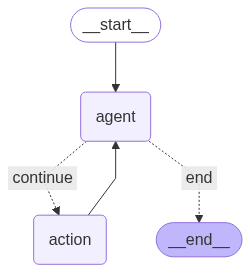

In [32]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [33]:
workflow.nodes, workflow.edges

({'agent': StateNodeSpec(runnable=agent(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None, input=<class '__main__.AgentState'>, retry_policy=None),
  'action': StateNodeSpec(runnable=action(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None, input=<class '__main__.AgentState'>, retry_policy=None)},
 {('__start__', 'agent'), ('action', 'agent')})

In [34]:
workflow.channels

{'input': <langgraph.channels.last_value.LastValue at 0x2a4da08e640>,
 'chat_history': <langgraph.channels.last_value.LastValue at 0x2a4bbda0880>,
 'agent_outcome': <langgraph.channels.last_value.LastValue at 0x2a4b4139b00>,
 'intermediate_steps': <langgraph.channels.binop.BinaryOperatorAggregate at 0x2a4b40ca940>}

In [35]:
inputs = {"input": "give me a random number and then write in words and make it upper case.", 
          "chat_history": []}
for s in graph.stream(inputs):
    print(list(s.values())[0])
    print("----")

{'agent_outcome': AgentActionMessageLog(tool='random_number', tool_input={'input': 'Generate a random number'}, log="\nInvoking: `random_number` with `{'input': 'Generate a random number'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"Generate a random number"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'service_tier': 'default'}, id='run--e23a2b2f-c8bd-4494-ba67-54e8f166b8f7-0')])}
----
The agent action is tool='random_number' tool_input={'input': 'Generate a random number'} log="\nInvoking: `random_number` with `{'input': 'Generate a random number'}`\n\n\n" message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"Generate a random number"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 

In [37]:
inputs = {"input": "give me a random number and then write in words and make it upper case", "chat_history": []}

output = graph.invoke(inputs)

The agent action is tool='random_number' tool_input={'input': 'any'} log="\nInvoking: `random_number` with `{'input': 'any'}`\n\n\n" message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"any"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_80956533cb', 'service_tier': 'default'}, id='run--db9f67d0-7976-44f9-aa08-f50284050993-0')]
The tool result is: 6
The agent action is tool='upper_case' tool_input={'input': 'six'} log="\nInvoking: `upper_case` with `{'input': 'six'}`\n\n\n" message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"six"}', 'name': 'upper_case'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_80956533cb', 'service_tier': 'default'}, id='run--e9e460ff-b590-43de-86de-c3ac1d739682-0')]
The tool result is: SIX


In [38]:
output

{'input': 'give me a random number and then write in words and make it upper case',
 'chat_history': [],
 'agent_outcome': AgentFinish(return_values={'output': 'The random number is **6**, and in words, it is **SIX**.'}, log='The random number is **6**, and in words, it is **SIX**.'),
 'intermediate_steps': [(AgentActionMessageLog(tool='random_number', tool_input={'input': 'any'}, log="\nInvoking: `random_number` with `{'input': 'any'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"any"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_80956533cb', 'service_tier': 'default'}, id='run--db9f67d0-7976-44f9-aa08-f50284050993-0')]),
   '6'),
  (AgentActionMessageLog(tool='upper_case', tool_input={'input': 'six'}, log="\nInvoking: `upper_case` with `{'input': 'six'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call

In [39]:
output.get('agent_outcome')

AgentFinish(return_values={'output': 'The random number is **6**, and in words, it is **SIX**.'}, log='The random number is **6**, and in words, it is **SIX**.')

In [40]:

output.get('agent_outcome').return_values['output']

'The random number is **6**, and in words, it is **SIX**.'

In [41]:
output['intermediate_steps']

[(AgentActionMessageLog(tool='random_number', tool_input={'input': 'any'}, log="\nInvoking: `random_number` with `{'input': 'any'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"any"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_80956533cb', 'service_tier': 'default'}, id='run--db9f67d0-7976-44f9-aa08-f50284050993-0')]),
  '6'),
 (AgentActionMessageLog(tool='upper_case', tool_input={'input': 'six'}, log="\nInvoking: `upper_case` with `{'input': 'six'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"six"}', 'name': 'upper_case'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_80956533cb', 'service_tier': 'default'}, id='run--e9e460ff-b590-43de-86de-c3ac1d739682-0')]),
  'SIX')]

### example 2: Chat Executor

In [42]:
os.environ["LANGCHAIN_PROJECT"] = "lg_02_chat_executor"

In [43]:
llm = ChatOpenAI(model="gpt-4o", streaming=True)

In [66]:
functions = [convert_to_openai_function(t) for t in tools]
llm = llm.bind_functions(functions)

In [67]:
functions

[{'name': 'upper_case',
  'description': 'Returns the input as all upper case.',
  'parameters': {'properties': {'input': {'type': 'string'}},
   'required': ['input'],
   'type': 'object'}},
 {'name': 'random_number',
  'description': 'Returns a random number between 0-100.',
  'parameters': {'properties': {'input': {'type': 'string'}},
   'required': ['input'],
   'type': 'object'}}]

### agent state

In [68]:
class AgentState(TypedDict):
    # 不断追加和传递
    messages: Annotated[Sequence[BaseMessage], operator.add]

### nodes

In [69]:
def should_continue(state):
    messages = state['messages']
    last_message = messages[-1]
    if "function_call" not in last_message.additional_kwargs:
        return "end"
    return "continue"

def call_model(state):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

def call_tool(state):
    messages = state['messages']
    last_message = messages[-1]
    action = ToolInvocation(
        tool=last_message.additional_kwargs["function_call"]["name"],
        tool_input=json.loads(last_message.additional_kwargs["function_call"]["arguments"]),
    )
    print(f"The agent action is {action}")
    response = tool_executor.invoke(action)
    print(f"The tool result is: {response}")
    function_message = FunctionMessage(content=str(response), name=action.tool)
    return {"messages": [function_message]}

### graph

In [70]:
workflow = StateGraph(AgentState)
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)
workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END
    }
)
workflow.add_edge('action', 'agent')
graph2 = workflow.compile()

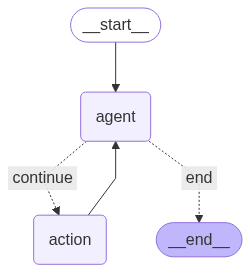

In [71]:
try:
    display(Image(graph2.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [72]:
system_message = SystemMessage(content="you are a helpful assistant")
user_q1 = HumanMessage(content="give me a random number and then write in words and make it upper case")
inputs = {"messages": [system_message, user_q1]}

In [73]:
output = graph2.invoke(inputs)

C:\Users\huang\AppData\Local\Temp\ipykernel_17972\3059577378.py:16: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(


The agent action is tool='random_number' tool_input={'input': 'Generate a random number'}
The tool result is: 68


C:\Users\huang\AppData\Local\Temp\ipykernel_17972\3059577378.py:16: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(


The agent action is tool='upper_case' tool_input={'input': 'sixty eight'}
The tool result is: SIXTY EIGHT


In [74]:
output

{'messages': [SystemMessage(content='you are a helpful assistant', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='give me a random number and then write in words and make it upper case', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"Generate a random number"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_80956533cb', 'service_tier': 'default'}, id='run--5f0f97ae-bf3a-44cd-a349-7ed3e9b23c5b-0'),
  FunctionMessage(content='68', additional_kwargs={}, response_metadata={}, name='random_number'),
  AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"sixty eight"}', 'name': 'upper_case'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_80956533cb', 'service_tier': 'default'}, id='run--62e996f3-10